In this notebook, we're going to build a regression model that rates the motor impairment severity of patients with Parkinson's disease using time-series gait data from the [Gait in Parkinson's Disease](https://www.physionet.org/content/gaitpdb/1.0.0/) dataset we examined in a previous session.

# Important: Run this code cell each time you start a new session!

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install os
!pip install librosa
!pip install scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import librosa
import sklearn

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
!wget -rNcnp https://physionet.org/files/gaitpdb/1.0.0/

--2024-07-18 22:56:11--  https://physionet.org/files/gaitpdb/1.0.0/
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘physionet.org/files/gaitpdb/1.0.0/index.html’

physionet.org/files     [ <=>                ]  36.17K  --.-KB/s    in 0.03s   

Last-modified header missing -- time-stamps turned off.
2024-07-18 22:56:11 (1.09 MB/s) - ‘physionet.org/files/gaitpdb/1.0.0/index.html’ saved [37036]

Loading robots.txt; please ignore errors.
--2024-07-18 22:56:11--  https://physionet.org/robots.txt
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 22 [text/plain]
Saving to: ‘physionet.org/robots.txt’

physionet.org/robot 100%[===================>]      22  --.-KB/s    in 0s      

2024-07-18 22:56:11 (14.0 MB/s) - ‘physionet.org/robots.txt’ saved [22/22]

--2024-07-18 2

# Step 1: Define the Problem You Are Trying to Solve

As a reminder, the goal of this dataset is to enable researchers to investigate whether characteristics of gait can be used to automatically monitor the severity of Parkinson's disease over time. This dataset is actually composed of data collected by three institutions. Together, these institutions recruited 93 patients with idiopathic PD and 73 healthy controls. During enrollment, subjects were asked to complete a number of clinical scales to assess the severity of their Parkinsonian symptoms. The clinical scale we will focus on the most is the Unified Parkinson's Disease Rating Scale (UPDRS). This scale is composed of four different parts, but we will focus on the portion that deals with motor control function (Part III).

During the study itself, subjects were asked to walk at their usual pace for approximately 2 minutes on level ground. Subjects were asked to repeat this protocol for multiple trials depending on the institution where the data was collected. Underneath each foot were 8 sensors that measure force (in Newtons) as a function of time; the researchers who compiled this dataset refer to the sensor data as the vertical ground reaction force (VGRF).  The output of each of these 16 sensors has been digitized and recorded at 100 Hz, and the records also include two signals that reflect the sum of the 8 sensor outputs for each foot.

| Column # | Description |
|----------|-------------|
| 1 | Time in seconds|
| 2–9 | VGRF on each of the 8 sensors located under the left foot |
|10–17 | VGRF on each of the 8 sensors located under the right foot |
| 18 | Total force under the left foot |
| 19 | Total force under the right foot |

The recording files are named according to the following convention: `{study_prefix}{subject_type}{subject_id}_{trial_id}.txt` (e.g., `GaCo01_01.txt`)

* `study_prefix`: Specifies the institution where the subject was recruited (either `Ga`, `Ju`, or `Si`)
* `subject_type`: Specifies whether the subject was a control (`Co`) or a patient (`Pt`)
* `subject_id`: Numerical identifier indicating the subject's number within the institution's cohort
* `trial_id`: Numerical identifier indicating the trial number. We will be using all trials except for any numbered `10`, which relates to a special protocol used by a single institution.

In [3]:
# The relevant folders and files associated with this dataset
base_folder = os.path.join('physionet.org', 'files', 'gaitpdb', '1.0.0')
label_filename = os.path.join(base_folder, 'demographics.xls')

In [4]:
# The names of the columns in the recordings
column_names = ['Time']
for i in range(1, 9):
    column_names.append(f'Left Sensor {i}')
for i in range(1, 9):
    column_names.append(f'Right Sensor {i}')
column_names.append('Left Foot')
column_names.append('Right Foot')

In [5]:
# Show the structure of one of the files
example_filename = 'GaCo01_01.txt'
example_df = pd.read_csv(os.path.join(base_folder, example_filename),
                         sep="\t", header=None, names=column_names)
example_df

,Time,Left Sensor 1,Left Sensor 2,Left Sensor 3,Left Sensor 4,Left Sensor 5,Left Sensor 6,Left Sensor 7,Left Sensor 8,Right Sensor 1,Right Sensor 2,Right Sensor 3,Right Sensor 4,Right Sensor 5,Right Sensor 6,Right Sensor 7,Right Sensor 8,Left Foot,Right Foot
0,0.0000,199.10,87.34,91.08,24.09,21.12,87.67,87.23,64.57,163.90,79.86,112.42,50.82,13.75,102.74,144.98,79.53,662.20,748.00
1,0.0100,199.10,87.34,91.08,24.09,21.12,87.67,87.23,64.57,163.90,79.86,112.42,50.82,13.75,102.74,144.98,79.53,662.20,748.00
2,0.0200,199.10,87.34,91.08,24.09,21.12,87.67,87.23,62.59,163.90,79.86,112.42,50.82,13.75,102.74,144.98,79.53,660.22,748.00
3,0.0300,199.10,87.34,91.08,24.09,21.12,87.67,89.10,64.57,163.90,77.55,112.42,48.07,13.75,105.49,144.98,79.53,664.07,745.69
4,0.0400,199.10,87.34,91.08,24.09,21.12,87.67,87.23,62.59,163.90,77.55,112.42,50.82,13.75,105.49,144.98,79.53,660.22,748.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12114,121.1315,305.91,85.14,58.08,0.00,0.00,0.00,0.00,0.00,15.73,11.66,4.73,33.88,33.00,255.42,432.19,147.29,449.13,933.90
12115,121.1415,331.54,134.75,79.31,11.99,0.00,3.85,0.00,0.00,15.73,9.35,4.73,11.22,24.75,230.34,420.42,151.80,561.44,868.34
12116,121.1515,352.44,181.94,102.96,39.60,0.00,17.49,2.97,0.00,13.97,9.35,4.73,5.61,19.25,192.39,402.82,154.00,697.40,802.12
12117,121.1615,352.44,202.40,124.74,43.01,8.47,50.71,7.59,0.00,13.97,6.93,0.00,0.00,13.75,143.66,373.34,151.80,789.36,703.45


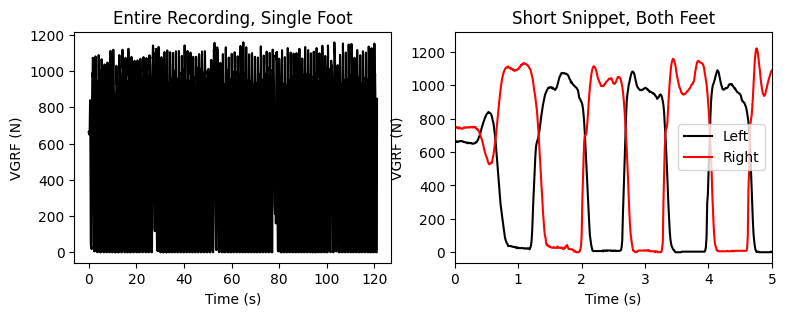

In [6]:
# Plot the data
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
plt.plot(example_df['Time'], example_df['Left Foot'], 'k-', label='Left')
plt.xlabel('Time (s)'), plt.ylabel('VGRF (N)'), plt.title('Entire Recording, Single Foot')
plt.subplot(1, 2, 2)
plt.plot(example_df['Time'], example_df['Left Foot'], 'k-', label='Left')
plt.plot(example_df['Time'], example_df['Right Foot'], 'r-', label='Right')
plt.xlabel('Time (s)'), plt.ylabel('VGRF (N)'), plt.title('Short Snippet, Both Feet')
plt.xlim(0, 5)
plt.legend()
plt.show()

There are many ways we could structure this problem. For instance, we could create a binary classifier designed to discriminate people with and without Parkinson's disease. For the sake of this exercise, however, we are going to build a ***regression model*** that will predict a person's UPDRS Part III score as the label based on their gait characteristics. To ensure that our dataset is not heavily skewed towards assuming that people do not have any motor impairments, we are only going to look at data from patients (e.g., with `Pt` in the recording filename).

# Step 2: Create Your Features and Labels

The labels for our dataset will be the UPDRSM associated with each recording.

Traditional machine learning models are not able to handle raw time-series data. Rather, they are best suited for handling tabular data. When we first saw this time-series dataset, we wrote a series of functions that allowed us to summarize gait characteristics according to arbitrary time-domain metrics, arbitrary frequency-domain metrics, and metrics that we calculated as a proxy for bradykinesia, rigidity, and postural instability. These numbers will serve as our features.

This goes to show that knowing about machine learning is often not enough to work with real-world data. Having some domain expertise relevant to the target task can ensure that you are able to extract meaningful features from your data.

All of the code from our initial exploration of this dataset is copied below, so refer to that notebook if you need a reminder of how we came up with these functions.

In [7]:
def compute_arbitrary_time_domain_metrics(times, values, fs=100):
    """
    Calculates generic time-domain statistics on the signal
    times: the times associated with the VGRF data
    values: the VGRF data
    fs: the sampling rate
    """
    return {'average': np.mean(values),
            'stdev': np.std(values),
            '95th percentile': np.percentile(values, 95),
            'rms': np.sqrt(np.mean(values**2))}

In [8]:
from numpy.fft import fftfreq
from scipy.fftpack import fft
from scipy import signal
def compute_arbitrary_freq_domain_metrics(times, values, fs=100):
    """
    Calculates generic frequency-domain statistics on the signal
    times: the times associated with the VGRF data
    values: the VGRF data
    fs: the sampling rate
    """
    # Calculate the FFT
    values_centered = values - values.mean()
    fft_mag = np.abs(fft(values_centered))
    fft_freqs = fftfreq(len(values_centered), 1/fs)

    # Calculate the indices relevant to our frequency bands of interest
    low_indices = np.where((fft_freqs >= 0) & (fft_freqs <= 3))
    high_indices = np.where((fft_freqs >= 3) & (fft_freqs <= 8))

    # Calculate the power at the low and high frequencies
    low_power = np.sum(fft_mag[low_indices]**2)
    high_power = np.sum(fft_mag[high_indices]**2)

    # Calculate the power within the frequency range
    high_to_low_ratio = 10*np.log10(high_power / low_power)
    return {'power at low freqs': low_power,
            'power at high freqs': high_power,
            'high-to-low power ratio': high_to_low_ratio}

In [9]:
def compute_amplitude_metrics(times, values, fs=100):
    """
    Calculate metrics related to the transient amplitude of the signal over time
    using a 5-second window with 0% overlap
    times: the times associated with the VGRF data
    values: the VGRF data
    fs: the sampling rate
    """
    # Set the sliding window parameters
    window_width = 5
    start_time = 0
    end_time = window_width
    sample_period = 1/fs
    middle_idx = int((window_width / sample_period) // 2)

    # Stop generating windows it would go past the end of the signal
    window_amplitudes = []
    while end_time < times.max():
        # Grab the current window by filtering indexes according to time
        window_idxs = (times >= start_time) & (times <= end_time)
        window_values = values[window_idxs]

        # Calculate the amplitude
        window_rms = np.sqrt(np.mean(window_values**2))
        window_amplitudes.append(window_rms)

        # Move the window over by a stride
        start_time += window_width
        end_time += window_width

    # Summarize the amplitude over time
    return {'average amplitude': np.mean(window_amplitudes),
            'stdev amplitude': np.std(window_amplitudes)}

In [10]:
def compute_cadence_metrics(times, values, fs=100):
    """
    Calculate metrics related to the transient peak frequency of the signal
    over time
    times: the times associated with the VGRF data
    values: the VGRF data
    fs: the sampling rate
    """
    # Calculate the spectrogram
    values_centered = values - values.mean()
    spec_freqs, spec_times, spectro = signal.spectrogram(values_centered, fs)

    # Find the largest bin along the frequency dimension
    dominant_bins = np.argmax(spectro, axis=0)

    # Map those bin indeces to frequencies
    peak_freqs = spec_freqs[dominant_bins]

    # Summarize the step rate over time
    return {'average cadence': np.mean(peak_freqs),
            'stdev cadence': np.std(peak_freqs)}

In [11]:
def compute_differences(left, right):
    """
    Compares corresponding metrics across two feet
    left: the dictionary of metrics from the left side
    right: the dictionary of metrics from the right side
    """
    diffs_dict = {}
    for key in left:
        diffs_dict[key] = np.abs(left[key] - right[key])
    return diffs_dict

This code is largerly the same as well. However, there are a few small housekeeping changes for both terminology and interfacing with `scikit-learn`:
1. **Terminology (Features):** What we originally called `info_dict` and `info_df` are now called `feature_dict` and `features_df` to reflect the fact that the metrics we extracted from our images will serve as our features.
2. **Terminology (Labels):** What we originally called `demo_df` is now called `labels_df` to reflect the fact that the diagnoses will serve as our labels.
3. **Adding demographic variables:** We have added some demographic variables (gender, age, weight) as features.
4. **Handling missing data (UPDRS):** Some subjects did not complete the UPDRS. Since we are doing supervised learning, there is little point in using their recordings to train our models and we will throw them out as before.
5. **Handling missing data (demographics):** The demographics variables were also not recorded for some subjects. Most machine learning techniques require all features to be present in order for them to work, so we will exclude any rows with missing data.
6. **Converting strings to numerics:** Because machine learning algorithms operate on numerical data, we have converted the gender column to a binary sex variable to a binary variable (`'male'` = `0`, `'female'` = `1`).
7. **Fixing improper data:** Contrary to the implications of the original header, the researchers responsible for collecting data from the `Ju` cohort actually reported height in centimeters rather than meters, so we will need to fix those ourselves.

In [12]:
def process_recording(filename):
    """
    Process a VGRF recording and produce all of the features as a dictionary
    (one value per key)
    filename: the name of the recording file
    """
    # Get the useful columns
    df = pd.read_csv(os.path.join(base_folder, filename),
                     sep="\t", header=None, names=column_names)
    time = df['Time'].values
    left_values = df['Left Foot'].values
    right_values = df['Right Foot'].values

    # Extract metrics from the left side
    left_time = compute_arbitrary_time_domain_metrics(time, left_values)
    left_freq = compute_arbitrary_freq_domain_metrics(time, left_values)
    left_amplitude = compute_amplitude_metrics(time, left_values)
    left_cadence = compute_cadence_metrics(time, left_values)

    # Extract metrics from the right side
    right_time = compute_arbitrary_time_domain_metrics(time, right_values)
    right_freq = compute_arbitrary_freq_domain_metrics(time, right_values)
    right_amplitude = compute_amplitude_metrics(time, right_values)
    right_cadence = compute_cadence_metrics(time, right_values)

    # Extract difference metrics
    diff_time = compute_differences(left_time, right_time)
    diff_freq = compute_differences(left_freq, right_freq)
    diff_amplitude = compute_differences(left_amplitude, right_amplitude)
    diff_cadence = compute_differences(left_cadence, right_cadence)

    # Combine everything into a dictionary
    feature_dict = {}
    for left_dict in [left_time, left_freq, left_amplitude, left_cadence]:
        for key in left_dict:
            feature_dict['Single foot ' + key] = left_dict[key]
    for diff_dict in [diff_time, diff_freq, diff_amplitude, diff_cadence]:
        for key in diff_dict:
            feature_dict['Difference ' + key] = diff_dict[key]
    return feature_dict

In [13]:
data_filenames = os.listdir(base_folder)

# Iterate through the filenames
features_df = pd.DataFrame()
for data_filename in data_filenames:
    # Skip the file if we want to ignore it
    patient_name = data_filename[0:6]
    patient_type = data_filename[2:4]
    trial_id = data_filename[7:9]
    if (patient_type == 'Co') or (trial_id == '10') or not ('_' in data_filename):
        continue

    # Generate the features
    feature_dict = process_recording(data_filename)

    # Add the patient's name as the identifier
    feature_dict['ID'] = patient_name
    feature_dict = pd.DataFrame([feature_dict])
    features_df = pd.concat([features_df, feature_dict], axis=0)

# Set the index to the image name
features_df.set_index(['ID'], inplace=True)
features_df

,Single foot average,Single foot stdev,Single foot 95th percentile,Single foot rms,Single foot power at low freqs,Single foot power at high freqs,Single foot high-to-low power ratio,Single foot average amplitude,Single foot stdev amplitude,Single foot average cadence,...,Difference stdev,Difference 95th percentile,Difference rms,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence
ID,,,,,,,,,,,,,,,,,,,,,
JuPt14,368.724078,309.336321,731.2800,481.296587,6.611166e+12,8.037159e+10,-19.151755,480.463136,11.597959,0.773738,...,20.695193,39.3800,28.872280,9.029947e+11,1.568242e+10,0.218105,30.150514,1.400941,0.007512,0.021474
GaPt16,452.808006,388.105046,970.4200,596.372885,1.093209e+13,1.084463e+11,-20.034885,596.426835,13.433749,0.810731,...,36.955258,88.2310,49.852721,2.153064e+12,3.011489e+10,0.283512,49.148285,0.196857,0.022111,0.029119
JuPt28,461.044277,404.422837,955.1300,613.285950,6.040012e+12,1.388950e+11,-16.383512,612.545817,17.864562,0.791530,...,12.178492,31.0145,24.117998,3.977355e+11,1.482753e+10,0.736343,23.065522,0.698314,0.000000,0.000000
JuPt01,565.852313,478.944191,1158.5805,741.334188,2.620189e+12,4.372803e+10,-17.775727,737.967662,18.264322,0.781250,...,30.786880,90.2385,71.291424,3.063015e+11,2.340713e+10,2.788266,66.875862,0.956544,0.000000,0.000000
GaPt33,517.066922,447.345331,1136.6300,683.722200,1.462482e+13,5.576751e+10,-24.187092,684.367827,17.342829,0.781250,...,26.652971,96.4700,19.167093,1.816863e+12,1.136433e+11,5.401705,20.091547,5.391908,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
JuPt18,434.976560,359.441352,884.9500,564.271826,4.470654e+13,1.845173e+11,-23.843338,562.919691,22.619539,0.737847,...,21.994030,57.7500,51.387605,5.672494e+12,6.224065e+09,0.667810,52.161499,8.617599,0.003339,0.004250
JuPt09,552.688317,482.587373,1201.0900,733.726754,1.074181e+13,4.836599e+11,-13.465373,732.812642,12.042190,1.071948,...,43.152801,105.0940,51.177848,1.738378e+12,1.812477e+11,1.272715,49.609170,0.617843,0.009084,0.005412
JuPt20,493.580845,436.167836,1113.6400,658.683863,7.827886e+12,2.393643e+11,-15.145851,658.835334,12.851302,1.028963,...,1.930453,7.4745,3.848188,4.495302e+10,2.769481e+10,0.508999,3.022789,3.795043,0.019055,0.022747


In [14]:
labels_df = pd.read_excel(label_filename, index_col='ID')
labels_df

,Study,Group,Subjnum,Gender,Age,Height (meters),Weight (kg),HoehnYahr,UPDRS,UPDRSM,TUAG,Speed_01 (m/sec),Speed_10
ID,,,,,,,,,,,,,
GaPt03,Ga,PD,3,female,82,1.45,50.0,3.0,20.0,10.0,36.34,NaN,0.778
GaPt04,Ga,PD,4,male,68,1.71,NaN,2.5,25.0,8.0,11.00,0.642,0.818
GaPt05,Ga,PD,5,female,82,1.53,51.0,2.5,24.0,5.0,14.50,0.908,0.614
GaPt06,Ga,PD,6,male,72,1.70,82.0,2.0,16.0,13.0,10.47,0.848,0.937
GaPt07,Ga,PD,7,female,53,1.67,54.0,3.0,44.0,22.0,18.34,0.677,0.579
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SiCo26,Si,CO,26,male,60,1.74,72.0,NaN,NaN,NaN,9.20,1.000,NaN
SiCo27,Si,CO,27,male,67,1.90,95.0,NaN,NaN,NaN,12.52,1.120,NaN
SiCo28,Si,CO,28,male,61,1.70,72.0,NaN,NaN,NaN,12.65,0.990,NaN


In [15]:
# Keep only patient data
labels_df = labels_df[labels_df['Group'] == 'PD']

# Get rid of unnecessary columns
labels_df = labels_df[['Gender', 'Age', 'Height (meters)',
                       'Weight (kg)', 'UPDRSM']]

# Rename the columns
labels_df.rename(columns={'Gender': 'Sex', 'Height (meters)': 'Height',
                          'Weight (kg)': 'Weight', 'UPDRSM': 'Label'}, inplace=True)
labels_df

,Sex,Age,Height,Weight,Label
ID,,,,,
GaPt03,female,82,1.45,50.0,10.0
GaPt04,male,68,1.71,NaN,8.0
GaPt05,female,82,1.53,51.0,5.0
GaPt06,male,72,1.70,82.0,13.0
GaPt07,female,53,1.67,54.0,22.0
...,...,...,...,...,...
SiPt36,female,53,1.58,62.0,32.0
SiPt37,female,66,1.70,62.0,21.0
SiPt38,female,65,1.59,60.0,14.0


In [16]:
# Convert gender to a binary sex variable
labels_df['Sex'] = labels_df['Sex'].replace({'male': 0, 'female': 1})
labels_df

,Sex,Age,Height,Weight,Label
ID,,,,,
GaPt03,1,82,1.45,50.0,10.0
GaPt04,0,68,1.71,NaN,8.0
GaPt05,1,82,1.53,51.0,5.0
GaPt06,0,72,1.70,82.0,13.0
GaPt07,1,53,1.67,54.0,22.0
...,...,...,...,...,...
SiPt36,1,53,1.58,62.0,32.0
SiPt37,1,66,1.70,62.0,21.0
SiPt38,1,65,1.59,60.0,14.0


In [17]:
# Fix the Ju rows so that the height is in meters
bad_height_rows = labels_df.index.str.startswith('Ju')
labels_df.loc[bad_height_rows, 'Height'] /= 100
labels_df

,Sex,Age,Height,Weight,Label
ID,,,,,
GaPt03,1,82,1.45,50.0,10.0
GaPt04,0,68,1.71,NaN,8.0
GaPt05,1,82,1.53,51.0,5.0
GaPt06,0,72,1.70,82.0,13.0
GaPt07,1,53,1.67,54.0,22.0
...,...,...,...,...,...
SiPt36,1,53,1.58,62.0,32.0
SiPt37,1,66,1.70,62.0,21.0
SiPt38,1,65,1.59,60.0,14.0


In [18]:
df = pd.merge(labels_df, features_df, how='right', left_index=True, right_index=True)
df

,Sex,Age,Height,Weight,Label,Single foot average,Single foot stdev,Single foot 95th percentile,Single foot rms,Single foot power at low freqs,...,Difference stdev,Difference 95th percentile,Difference rms,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence
ID,,,,,,,,,,,,,,,,,,,,,
GaPt03,1,82,1.45,50.0,10.0,343.433216,282.427944,700.480,444.648082,5.831105e+12,...,19.256839,45.760,28.706597,8.148191e+11,1.105764e+10,1.152139,27.958919,0.175975,0.007370,0.007586
GaPt04,0,68,1.71,NaN,8.0,465.003393,390.598070,947.320,607.284948,1.112393e+13,...,5.202262,18.161,21.197996,3.134335e+11,1.261027e+10,0.901248,22.115557,2.678798,0.007370,0.021288
GaPt05,1,82,1.53,51.0,5.0,411.277901,361.974491,820.941,547.882326,9.440699e+12,...,22.689266,36.311,29.221993,1.121864e+12,4.227267e+10,0.677072,29.502260,1.132740,0.000000,0.000000
GaPt06,0,72,1.70,82.0,13.0,557.588702,458.914602,1121.450,722.154951,1.530548e+13,...,5.647152,53.240,28.060753,3.435866e+11,2.775412e+10,0.847240,28.458919,4.186961,0.000000,0.000000
GaPt07,1,53,1.67,54.0,22.0,319.467148,253.540123,684.794,407.850282,4.682924e+12,...,27.310022,38.467,40.351675,1.015065e+12,4.931373e+10,2.944462,39.142952,3.350562,0.007370,0.012917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SiPt36,1,53,1.58,62.0,32.0,358.826789,318.359561,786.500,479.697274,7.337781e+12,...,7.901679,0.319,38.302982,3.132062e+11,5.968487e+10,1.928532,38.333603,4.064862,0.014741,0.037119
SiPt37,1,66,1.70,62.0,21.0,345.079721,284.386913,729.630,447.164321,5.848238e+12,...,11.187253,13.640,8.534774,4.154555e+11,6.003682e+10,2.213339,8.545315,7.355853,0.000000,0.000000
SiPt38,1,65,1.59,60.0,14.0,326.260917,273.404894,670.010,425.671730,5.399695e+12,...,5.800428,9.361,6.813105,2.576747e+11,1.649682e+10,1.272530,6.793150,0.431877,0.007370,0.053148


In [19]:
# Remove rows with missing data
df = df.dropna(how='any')
df

,Sex,Age,Height,Weight,Label,Single foot average,Single foot stdev,Single foot 95th percentile,Single foot rms,Single foot power at low freqs,...,Difference stdev,Difference 95th percentile,Difference rms,Difference power at low freqs,Difference power at high freqs,Difference high-to-low power ratio,Difference average amplitude,Difference stdev amplitude,Difference average cadence,Difference stdev cadence
ID,,,,,,,,,,,,,,,,,,,,,
GaPt03,1,82,1.45,50.0,10.0,343.433216,282.427944,700.480,444.648082,5.831105e+12,...,19.256839,45.760,28.706597,8.148191e+11,1.105764e+10,1.152139,27.958919,0.175975,0.007370,0.007586
GaPt05,1,82,1.53,51.0,5.0,411.277901,361.974491,820.941,547.882326,9.440699e+12,...,22.689266,36.311,29.221993,1.121864e+12,4.227267e+10,0.677072,29.502260,1.132740,0.000000,0.000000
GaPt06,0,72,1.70,82.0,13.0,557.588702,458.914602,1121.450,722.154951,1.530548e+13,...,5.647152,53.240,28.060753,3.435866e+11,2.775412e+10,0.847240,28.458919,4.186961,0.000000,0.000000
GaPt07,1,53,1.67,54.0,22.0,319.467148,253.540123,684.794,407.850282,4.682924e+12,...,27.310022,38.467,40.351675,1.015065e+12,4.931373e+10,2.944462,39.142952,3.350562,0.007370,0.012917
GaPt07,1,53,1.67,54.0,22.0,307.865112,258.855856,686.191,402.227897,4.826506e+12,...,35.847545,49.049,48.585464,1.296596e+12,1.399435e+11,3.160799,48.727985,3.704750,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SiPt36,1,53,1.58,62.0,32.0,358.826789,318.359561,786.500,479.697274,7.337781e+12,...,7.901679,0.319,38.302982,3.132062e+11,5.968487e+10,1.928532,38.333603,4.064862,0.014741,0.037119
SiPt37,1,66,1.70,62.0,21.0,345.079721,284.386913,729.630,447.164321,5.848238e+12,...,11.187253,13.640,8.534774,4.154555e+11,6.003682e+10,2.213339,8.545315,7.355853,0.000000,0.000000
SiPt38,1,65,1.59,60.0,14.0,326.260917,273.404894,670.010,425.671730,5.399695e+12,...,5.800428,9.361,6.813105,2.576747e+11,1.649682e+10,1.272530,6.793150,0.431877,0.007370,0.053148


# Step 3: Decide How the Data Should Be Split for Training and Testing

Because we have multiple trials from the same subjects, we cannot just use the `train_test_split()` function in order to split our dataset. Otherwise, we run the risk of having a subject's data across multiple splits. Unless we expect that subjects will provide labeled data as a sort of "personal calibration" for model training, this would constitute information leakage.

What we need to do is split the data while being cognizant that rows with the same `ID` should be grouped together. One convenient way we can do that is by using the `GroupKFold` class in `scikit-learn`. This object splits data according to k-fold cross-validation while keeping all of the samples associated with the same grouping variable in the same fold.

In the example below, we can see how `GroupKFold` splits our data into 5 folds while using the index of our `DataFrame` as the grouping variable:

In [20]:
from sklearn.model_selection import GroupKFold

# Set the random seed to an arbitrary number of your choosing
np.random.seed(42)

# Get the features, labels, and grouping variables
x = df.drop('Label', axis=1).values
y = df['Label'].values
groups = df.index.values

# Split the data into folds
group_kfold = GroupKFold(n_splits=5)
for train_idxs, test_idxs in group_kfold.split(x, y, groups):
    print(f'Train row idxs: {train_idxs}')
    print(f'Test row idxs: {test_idxs}')
    print('---------------')

Train row idxs: [  0   2   3   4   5   6   7   8  11  12  13  14  15  16  17  18  21  22
  23  24  25  26  27  28  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  69  70  71  72  73  74  75  76  77  78  79  80  81  90  91  92  93
  94  95  96  97  98  99 100 102 103 104 105 106 107 108 109 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 150 151 152 153 155 156 157
 158 160 161 162 163 165 166 167 168 170 171 172 173 175 176 177 178 180
 181]
Test row idxs: [  1   9  10  19  20  29  30  45  46  47  48  49  50  68  82  83  84  85
  86  87  88  89 101 110 111 112 113 114 115 116 149 154 159 164 169 174
 179]
---------------
Train row idxs: [  1   2   3   4   5   6   7   8   9  10  13  14  15  16  17  18  19  20
  23  24  25  26  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54 

There are more sophisiticated functions and classes we can use to automate the entire cross-validation procedure for us. However, we will get to that in a bit.

# Step 4: (Optional) Add Feature Selection

We have explicitly included features that are inspired by domain expertise and our general knowledge about signal processing so that we can eventually try out feature selection. However, we are going to skip this step for now.

# Step 5: (Optional) Balance Your Dataset

Although there aren't distinct classes we can balance, we can still check that we have a reasonable distribution of UPDRSM scores. We will use this opportunity to show one of the ways that `pandas` interfaces with `matplotlib` to simplify how you can visualize data:

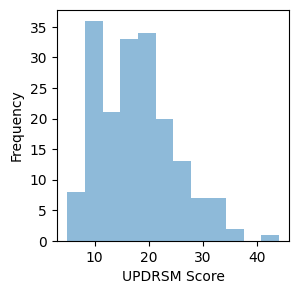

In [21]:
plt.figure(figsize=(3, 3))
df['Label'].plot.hist(bins=12, alpha=0.5)
plt.xlabel('UPDRSM Score')
plt.show()

Ideally, this would be a completely normal distribution with taller bars in the middle and shorter bars on either side. Although that isn't what we see here, most of the scores lie between 15–20 and we have scores that are above and below that range. Since there is no glaring imbalance in our dataset, it is probably not worth trying to balance our dataset and adding yet another step in our pipeline.

# Step 6: Select an Appropriate Model

`scikit-learn` provides numerous regression model architectures with their own advantages and disadvantages. We are going to use a ***k-nearest neighbors regressor***, which makes predictions by taking the average label of samples from the training set with similar features.

In [22]:
from sklearn.neighbors import KNeighborsRegressor
reg = KNeighborsRegressor()

Something you may be thinking right now is that our features have different ranges, which complicates how a k-nearest neighbors regressor identifies neighboring samples. Points will be closer according to features with smaller ranges, so those features will have a stronger influence on how neighbors are deteremined. We can fix this by normalizing the distributions of our features.

However, we are not going to do this until the next lecture. Part of the reason why we are going to forgo this step for now is that it is not required for all model architectures. For example, decision trees and random forests are scale-invariant; regardless of the range of a feature, a decision boundary can be selected to split the data in the exact same way.

# Step 7: (Optional) Select Your Hyperparameters

K-nearest neighbor regression has a fairly obvious hyperparameter: the number of neighbors we use to make our predictions. The default value is 5, and we are going to keep it that way for simplicity.

# Step 8: Train and Test Your Model

As with classification models, we can train a regression model by calling `.fit()` and generate predictions using `.predict()`. Since the predictions are going to be continuous values, there is no equivalent to the `.predict_proba()` method.

Sicne we are doing k-fold cross-validation, our train-and-test procedure is going to be more complicated. The pseudocode for the procedure is as follows:

```
initialize a data structure for saving our final results
for each fold:
    split data into train and test
    train a model on training data
    predict on the test data using that model
    add the predictions to our final results data structure
```

And here is that procedure in action:

In [23]:
# Set the random seed to an arbitrary number of your choosing
np.random.seed(42)

# Initialize a data structure to save our final results,
# assuming all of the predictions are 0 to start
y_pred = np.zeros(y.shape)

# Get the features, labels, and grouping variables
x = df.drop('Label', axis=1).values
y = df['Label'].values
groups = df.index.values

# Split the data into folds
group_kfold = GroupKFold(n_splits=5)
for train_idxs, test_idxs in group_kfold.split(x, y, groups):
    # Split the data into train and test
    x_train = x[train_idxs]
    y_train = y[train_idxs]
    x_test = x[test_idxs]
    y_test = y[test_idxs]

    # Train a model on the training data
    reg = KNeighborsRegressor()
    reg.fit(x_train, y_train)

    # Predict on the test data
    y_test_pred = reg.predict(x_test)
    y_pred[test_idxs] = y_test_pred

`scikit-learn` provides a function called `cross_val_predict()` that will automate this procedure for us:

In [24]:
from sklearn.model_selection import cross_val_predict

# Perform cross-validation and get the predictions
y_pred = cross_val_predict(reg, x, y, groups=groups, cv=5)

However, we are going to stick with our manual implementation for two reasons: (1) doing it ourselves will reinforce what this procedure is doing, and (2) it will give us greater flexibility to change our pipeline in a later session.

As you get more familiar with `scikit-learn` and machine learning in general, you will discover for yourself which shortcuts you want to rely on.

# Step 9: Use an Appropriate Method for Interpreting Results

Now that we have predictions, we will examine a variety of metrics to see how well our model performed. Most of the functions we will discuss in this section require two inputs:
1. **y_true:** The known ground-truth labels from our dataset
2. **y_pred:** The labels predicted from the model

## Distance Metrics

The `metrics` module from `scikit-learn` provides multiple functions for evaluating the performance of a regression model. However, some of the most useful ones can be calculated using simply `numpy` operations:

In [25]:
print(f'Mean error: {np.mean(y_pred-y)}')
print(f'Mean absolute error: {np.mean(np.abs(y_pred-y))}')

Mean error: 0.6351648351648351
Mean absolute error: 5.876923076923077


## Correlation Metrics

`scipy` provides functions for calculating both Pearson's and Spearman's correlation. These functions return a special object that contains two values: the correlation coefficient and its p-value.

In [26]:
from scipy.stats import pearsonr, spearmanr

pcorr = pearsonr(y, y_pred)
scorr = spearmanr(y, y_pred)
print(f'Pearson correlation: r = {pcorr[0]:0.2f}, pval = {pcorr[1]:0.2f}')
print(f'Spearman correlation: r = {scorr[0]:0.2f}, pval = {scorr[1]:0.2f}')

Pearson correlation: r = 0.13, pval = 0.08
Spearman correlation: r = 0.16, pval = 0.03


Although interpretations of the relationship strength can vary between disciplines, the table below gives general rules of thumb:

| Range | Interpretation | Direction
|-------|------|------|
| Between 0.5 and 1 | Strong | Positive |
| Between 0.3 and 0.5 | Moderate | Positive |
| Between 0 and 0.3 | Weak | Positive |
| 0 | No correlation | N/A |
| Between -0.3 and 0 | Weak | Negative |
| Between -0.5 and -0.3 | Moderate | Negative |
| Between -1 and -0.5 | Strong | Positive |

We calculate the R2 score, also known as the coefficient of determination. Similar conventions can be applied here.

In [27]:
from sklearn.metrics import r2_score

print(f'R2 Score: {r2_score(y, y_pred)}')

R2 Score: -0.16893358064720276


To establish these correlation results further, we can plot them on a correlation plot:

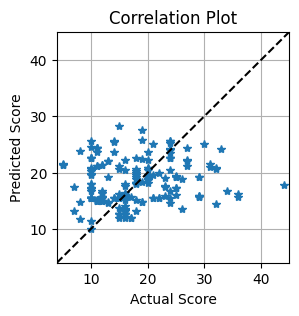

In [28]:
fig_bounds = [y.min()-1, y.max()+1]
plt.figure(figsize=(3, 3))
plt.plot(y, y_pred, '*')
plt.plot(fig_bounds, fig_bounds, 'k--')
plt.grid()
plt.xlim(fig_bounds), plt.ylim(fig_bounds)
plt.xlabel('Actual Score'), plt.ylabel('Predicted Score')
plt.title('Correlation Plot')
plt.show()

Another graph that can be useful for analyzing regression performance is a ***Bland-Altmann plot***. These graphs are designed to show how the agreement between two measurement methods varies according to their magnitude. Typically, the x-axis of these graphs is the average between the measurement methods (in this case, known labels and their corresponding predictions) and the y-axis is the difference between them.

However, this is the case when one measurement method does not take precedence over another. In our case, we know that one of the measurement methods is "correct". Therefore, we will create a modified Bland-Altmann plot where the x-axis is the known label and the y-axis is the difference between the prediction and the known label.

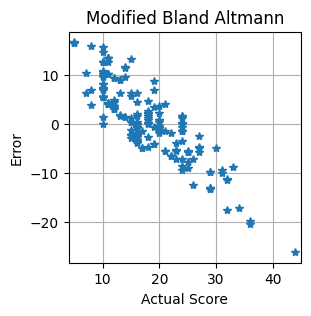

In [29]:
plt.figure(figsize=(3, 3))
plt.plot(y, y_pred-y, '*')
plt.grid()
plt.xlim(fig_bounds)
plt.xlabel('Actual Score'), plt.ylabel('Error')
plt.title('Modified Bland Altmann')
plt.show()

## Evaluating Performance

Let's create a function that will generate a detailed regression accuracy report combining the aforementioned metrics and visualizations:

In [30]:
def regression_evaluation(y_true, y_pred):
    """
    Generate a series of graphs that will help us determine the performance of
    a regression model
    y_true: the target labels
    y_pred: the predicted labels
    """
    # Calculate the distance metrics and Pearson's correlation
    mean_error = np.mean(y_pred-y)
    std_error = np.std(y_pred-y)
    mean_absolute_error = np.mean(np.abs(y_pred-y))
    corr, pval = pearsonr(y, y_pred)

    # Set up the graphs
    fig_bounds = [y.min()-1, y.max()+1]
    corr_title = f'Correlation = {corr:0.2f}'
    corr_title += ', p<.05' if pval <.05 else ', n.s.'
    ba_title = f'Mean Error = {mean_error:0.2f} ± {std_error:0.2f}'

    # Generate a correlation plot with the scores in the title
    plt.figure(figsize=(9, 3))
    plt.subplot(1, 2, 1)
    plt.plot(y, y_pred, '*')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
    plt.grid()
    plt.xlim(fig_bounds), plt.ylim(fig_bounds)
    plt.xlabel('Actual Score'), plt.ylabel('Predicted Score')
    plt.title(corr_title)

    plt.subplot(1, 2, 2)
    plt.plot(y, y_pred-y, '*')
    plt.axhline(y=mean_error, color='k', linestyle='--')
    plt.axhline(y=mean_error+std_error, color='r', linestyle='--')
    plt.axhline(y=mean_error-std_error, color='r', linestyle='--')
    plt.xlim(fig_bounds)
    plt.xlabel('Actual Score'), plt.ylabel('Error')
    plt.title(ba_title)
    plt.show()

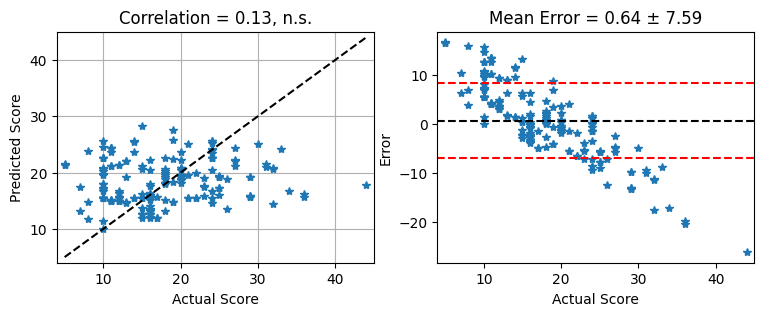

In [31]:
regression_evaluation(y, y_pred)

So what can we learn from these results:
* Our model did not achieve a statistically significant correlation between our predictions and the labels.
* Our model has a tendency to overpredict scores given that the mean error is 0.65.
* Notice that all of our predictions are generally between 15–25 regardless of the label. This may be because most of the samples within our dataset fall within that range. When a regression model is biased in this way, some data scientists will say that it is ***mean tracking*** in the sense that its predictions tend to hover around the average in the dataset.
* The mean tracking is even more evident in the Bland-Altman. Notice how it has a diagonal shape that trends from the top-left to the bottom-right. This means that the model tends to overestimate lower scores and underestimate higher scores, which is exactly what if the model were always predicting the average label.

We are going to revisit this machine learning pipeline in a later session to see how we can improve its performance.